# Rank selection

In [1]:
import numpy as np
import h5py
import torch

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jan 16 09:48:38 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
# Import google drive mounting module
from google.colab import drive

# Import os/path lib to navigate the colab directory.
import os
import pathlib


# Mount Google Drive at the default location
drive.mount('/content/drive', force_remount=False)
# Define the path to your desired folder
path = '/content/drive/My Drive/OPM-MEG'
# Change to that directory
os.chdir(path)
# Verify the current working directory
print("Current Directory:", os.getcwd())

Mounted at /content/drive
Current Directory: /content/drive/My Drive/OPM-MEG


In [4]:
!git clone https://github.com/hug0-w/Tensor-Decompositions-OPM-MEG/
!pip install tensorly

Cloning into 'Tensor-Decompositions-OPM-MEG'...
remote: Enumerating objects: 341, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 341 (delta 12), reused 18 (delta 6), pack-reused 316 (from 1)
Receiving objects: 100% (341/341), 27.69 MiB | 25.09 MiB/s, done.
Resolving deltas: 100% (159/159), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 66.2 MB/s eta 0:00:00


In [5]:
mat_path = "outcome_pow_trial_chan_fbin_time_ds500_tpos.mat"

with h5py.File(mat_path, "r") as f:

    # --- main data ---
    # HDF5 reads MATLAB v7.3 arrays with transposed dimensions.
    # MATLAB Saved: [Trials, Chan, Freqs, Time]
    # Python Reads: (Time, Freqs, Chan, Trials)
    Pow = np.array(f["Pow"])

    freq = np.array(f["freq"]).squeeze()
    time = np.array(f["time"]).squeeze()

    # Removed: fbins = np.array(f["fbins"])
    freqs_hz = np.array(f["freqs_hz"]).squeeze()

    ds_fs = float(np.array(f["ds_fs"]).squeeze())
    fs_orig = float(np.array(f["fs_orig"]).squeeze())

    # --- channel labels (MATLAB cellstr) ---
    # MATLAB cell arrays of strings are stored as object references in HDF5
    ch_names_refs = f["chan_lbl"][()]
    chan_lbl = []
    for r in ch_names_refs.flatten():
        s = f[r][()]
        # MATLAB v7.3 stores strings as uint16 (utf-16le)
        chan_lbl.append(s.tobytes().decode("utf-16le").rstrip("\x00"))

    # --- MNE metadata ---
    mne_grp = f["mne"]

    ch_names_refs = mne_grp["ch_names"][()]
    mne_ch_names = []
    for r in ch_names_refs.flatten():
        s = f[r][()]
        mne_ch_names.append(s.tobytes().decode("utf-16le").rstrip("\x00"))

    ch_pos_m = np.array(mne_grp["ch_pos_m"], dtype=float)
    # MATLAB stored (N, 3), HDF5 reads (3, N). Transpose to get (N_chan, 3).
    if ch_pos_m.shape[0] == 3 and ch_pos_m.shape[1] != 3:
        ch_pos_m = ch_pos_m.T

    # Decode coordinate frame string (e.g., 'head')
    coord_frame_data = mne_grp["coord_frame"][()]
    try:
        coord_frame = coord_frame_data.tobytes().decode("utf-16le").rstrip("\x00")
    except AttributeError:
        # Fallback if it loaded as a simple byte string or char
        coord_frame = str(coord_frame_data)

In [6]:
Pow.shape

(751, 35, 121, 195)

In [7]:
log_Pow = np.log(Pow+1e-10)

In [8]:
log_Pow = log_Pow.T

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
log_Pow_torch = torch.as_tensor(log_Pow, device=device, dtype=torch.float32)

In [22]:
%cd Tensor-Decompositions-OPM-MEG/
from src.tools.rankselection import rank_fit, rel_error

[Errno 2] No such file or directory: 'Tensor-Decompositions-OPM-MEG/'
/content/drive/MyDrive/OPM-MEG/Tensor-Decompositions-OPM-MEG


In [17]:
import tensorly as tl
tl.set_backend('pytorch')

In [18]:
from tqdm import tqdm

In [20]:
from tensorly.decomposition import non_negative_parafac_hals

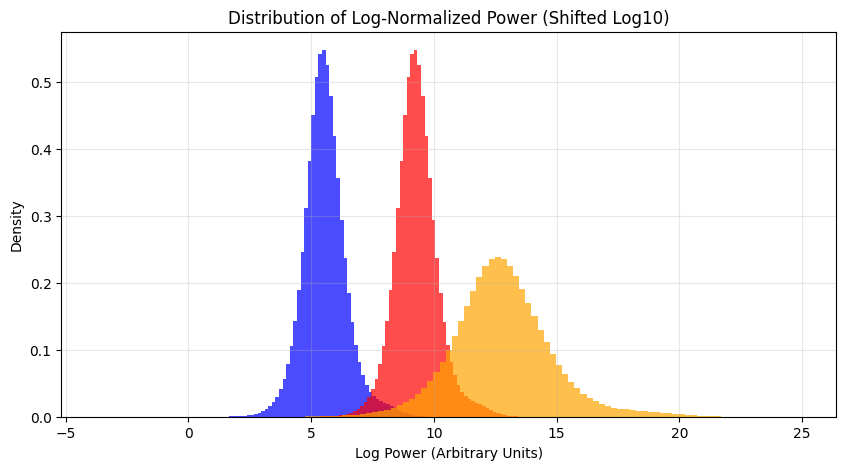

Minimum Value: -3.743088483810425
Is all positive? False


In [55]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Apply Option 2: Shifted Log (dB-like)
# Add a tiny epsilon to avoiding log(0) issues if you have exact zeros
epsilon = 1e-20
log_Pow = np.log10(Pow + epsilon)
log_Pow_1p = np.log1p(Pow)
# Shift so the minimum is 0 (optional, but helpful for non-negative decomposition)
# This makes it similar to a dB scale relative to the noise floor
log_Pow_shifted = log_Pow - np.min(log_Pow)

# 2. Plot the Distribution
plt.figure(figsize=(10, 5))
plt.hist(log_Pow.ravel(), bins=100, density=True, color='blue', alpha=0.7)
plt.hist(log_Pow_shifted.ravel(), bins=100, density=True, color='red', alpha=0.7)
plt.hist(log_Pow_1p.ravel(), bins=100, density=True, color='orange', alpha=0.7)

plt.title("Distribution of Log-Normalized Power (Shifted Log10)")
plt.xlabel("Log Power (Arbitrary Units)")
plt.ylabel("Density")
plt.grid(True, alpha=0.3)
plt.show()

# 3. Check for Non-Negativity (Required for Non-Negative CP)
print(f"Minimum Value: {np.min(log_Pow)}")
print(f"Is all positive? {np.all(log_Pow >= 0)}")

In [64]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
log_Pow_shifted_torch = torch.as_tensor(Pow.T, device=device, dtype=torch.float32)

In [76]:
ranks = range(1,21,1)

errors = []

for i in tqdm(ranks):
   cp_tensor = non_negative_parafac_hals(
                log_Pow_shifted_torch,
                rank=i,
                init="random",
                n_iter_max=2000,
                tol=1e-6,
                random_state=5  # Ensure different random init
            )
   rel_err = rel_error(log_Pow_shifted_torch, cp_tensor)
   errors.append(rel_err)

100%|██████████| 20/20 [41:54<00:00, 125.71s/it]


In [78]:
fit = [(1-f.to('cpu').numpy()) for f in errors]

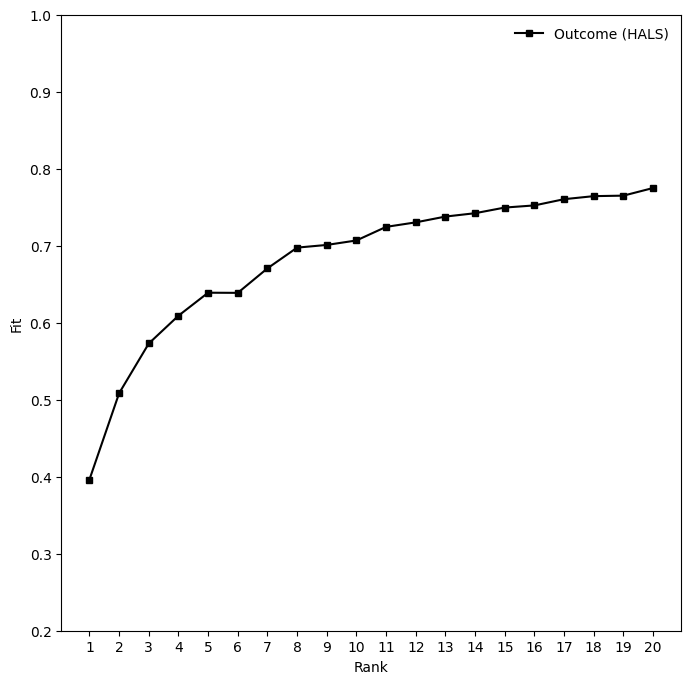

In [112]:
plt.subplots(figsize=(8,8))
plt.plot(ranks,fit,color='black',marker='s',markersize=4,label='Outcome (HALS)')
plt.xlabel('Rank')
plt.ylabel('Fit')
plt.ylim(0.2,1)
plt.xticks(ranks)
plt.legend(framealpha=0)

In [114]:
%cd ..

/content/drive/MyDrive/OPM-MEG


In [115]:
mat_path = "choice_pow_trial_chan_fbin_time_ds500_tpos.mat"

with h5py.File(mat_path, "r") as f:

    # --- main data ---
    # HDF5 reads MATLAB v7.3 arrays with transposed dimensions.
    # MATLAB Saved: [Trials, Chan, Freqs, Time]
    # Python Reads: (Time, Freqs, Chan, Trials)
    Pow = np.array(f["Pow"])

    freq = np.array(f["freq"]).squeeze()
    time = np.array(f["time"]).squeeze()

    # Removed: fbins = np.array(f["fbins"])
    freqs_hz = np.array(f["freqs_hz"]).squeeze()

    ds_fs = float(np.array(f["ds_fs"]).squeeze())
    fs_orig = float(np.array(f["fs_orig"]).squeeze())

    # --- channel labels (MATLAB cellstr) ---
    # MATLAB cell arrays of strings are stored as object references in HDF5
    ch_names_refs = f["chan_lbl"][()]
    chan_lbl = []
    for r in ch_names_refs.flatten():
        s = f[r][()]
        # MATLAB v7.3 stores strings as uint16 (utf-16le)
        chan_lbl.append(s.tobytes().decode("utf-16le").rstrip("\x00"))

    # --- MNE metadata ---
    mne_grp = f["mne"]

    ch_names_refs = mne_grp["ch_names"][()]
    mne_ch_names = []
    for r in ch_names_refs.flatten():
        s = f[r][()]
        mne_ch_names.append(s.tobytes().decode("utf-16le").rstrip("\x00"))

    ch_pos_m = np.array(mne_grp["ch_pos_m"], dtype=float)
    # MATLAB stored (N, 3), HDF5 reads (3, N). Transpose to get (N_chan, 3).
    if ch_pos_m.shape[0] == 3 and ch_pos_m.shape[1] != 3:
        ch_pos_m = ch_pos_m.T

    # Decode coordinate frame string (e.g., 'head')
    coord_frame_data = mne_grp["coord_frame"][()]
    try:
        coord_frame = coord_frame_data.tobytes().decode("utf-16le").rstrip("\x00")
    except AttributeError:
        # Fallback if it loaded as a simple byte string or char
        coord_frame = str(coord_frame_data)

In [117]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Pow_torch = torch.as_tensor(Pow.T, device=device, dtype=torch.float32)

In [118]:
ranks = range(1,21,1)

errors_choice = []

for i in tqdm(ranks):
   cp_tensor = non_negative_parafac_hals(
                log_Pow_shifted_torch,
                rank=i,
                init="random",
                n_iter_max=2000,
                tol=1e-6,
                random_state=5  # Ensure different random init
            )
   rel_err = rel_error(log_Pow_shifted_torch, cp_tensor)
   errors_choice.append(rel_err)

100%|██████████| 20/20 [52:47<00:00, 158.38s/it]


In [119]:
fit_choice = [(1-f.to('cpu').numpy()) for f in errors_choice]

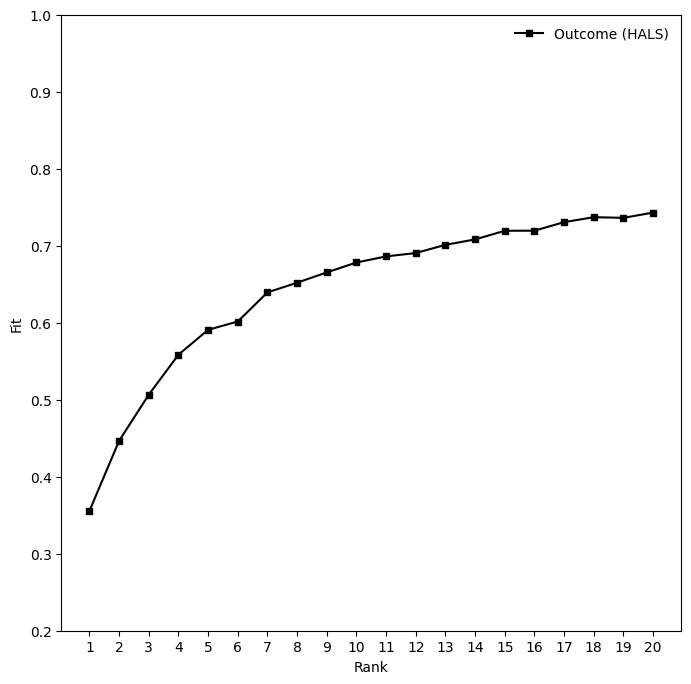

In [125]:
plt.subplots(figsize=(8,8))
plt.plot(ranks,fit_choice,color='black',marker='s',markersize=4,label='Outcome (HALS)')
plt.xlabel('Rank')
plt.ylabel('Fit')
plt.ylim(0.2,1)
plt.xticks(ranks)
plt.legend(framealpha=0)

In [171]:
%pwd

'/content/drive/MyDrive/OPM-MEG'

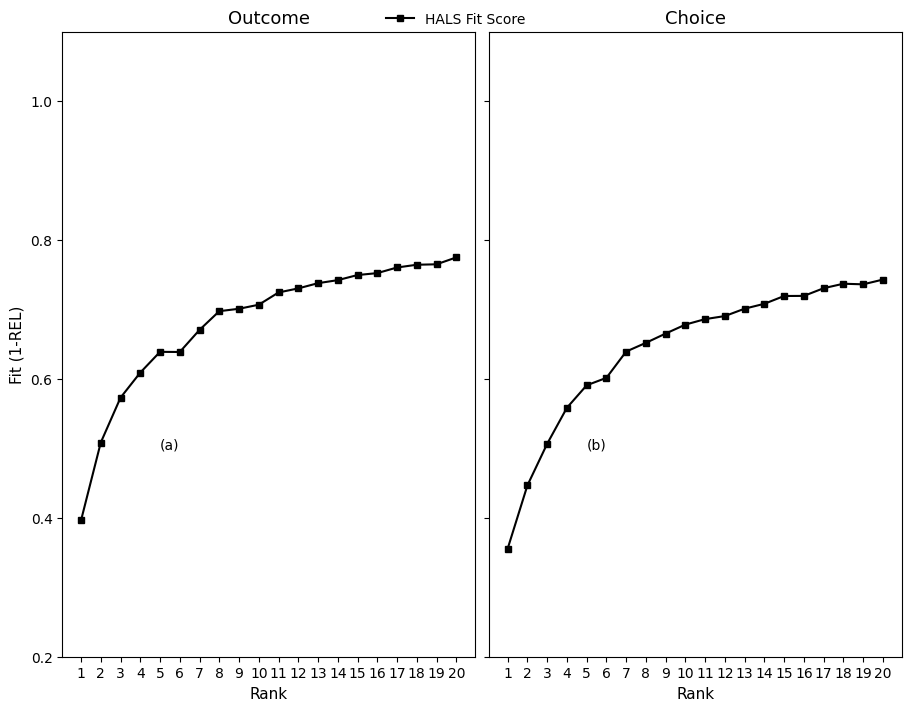

In [178]:
fig, ax = plt.subplots(1,2,figsize=(9,7),sharey=True,constrained_layout=True)

ax[0].plot(ranks,fit,color='black',marker='s',markersize=4,label='HALS Fit Score')
ax[0].set_ylim(0,1.1)
ax[0].set_title('Outcome',fontsize=13)
ax[0].set_xticks(ranks)
ax[0].set_ylabel("Fit (1-REL)",fontsize=11)
ax[0].set_xlabel('Rank',fontsize=11)

ax[1].plot(ranks,fit_choice,color='black',marker='s',markersize=4,label='Outcome (HALS)')
ax[1].set_ylim(0.2,1.1)
ax[1].set_title('Choice',fontsize=13)
ax[1].set_xticks(ranks)
ax[1].set_xlabel('Rank',fontsize=11)




ax[0].text(5,0.5,'(a)')
ax[1].text(5,0.5,'(b)')

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=1, frameon=False)
plt.savefig("cp_rank_fit.svg", dpi=300, bbox_inches="tight")